###  学习目标
学习特征预处理、缺失值、异常值处理、数据分桶等特征处理方法

学习特征交互、编码、选择的相应方法

完成相应学习打卡任务，两个选做的作业不做强制性要求，供学有余力同学自己探索

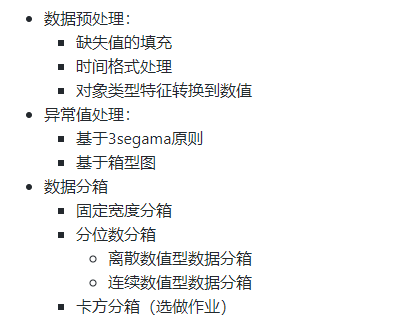

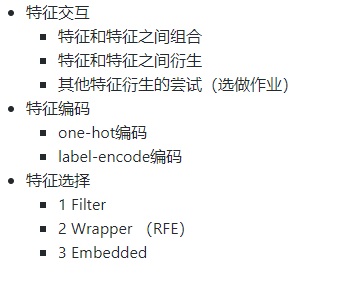

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold  
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score,log_loss
warnings.filterwarnings('ignore')

In [4]:
data_train = pd.read_csv(r'D:\MyData\chenpf8\TianChi_Data\01_Introduction to Financial risk control - Loan default prediction\train.csv' ,
                   encoding='UTF-8', index_col=0,header=0)
data_test = pd.read_csv(r'D:\MyData\chenpf8\TianChi_Data\01_Introduction to Financial risk control - Loan default prediction\testA.csv' ,
                   encoding='UTF-8', index_col=0,header=0)

###  特征预处理

数据EDA部分我们已经对数据的大概和某些特征分布有了了解，数据预处理部分一般我们要处理一些EDA阶段分析出来的问题，这里介绍了数据缺失值的填充，时间格式特征的转化处理，某些对象类别特征的处理。

首先我们查找出数据中的对象特征和数值特征

In [5]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

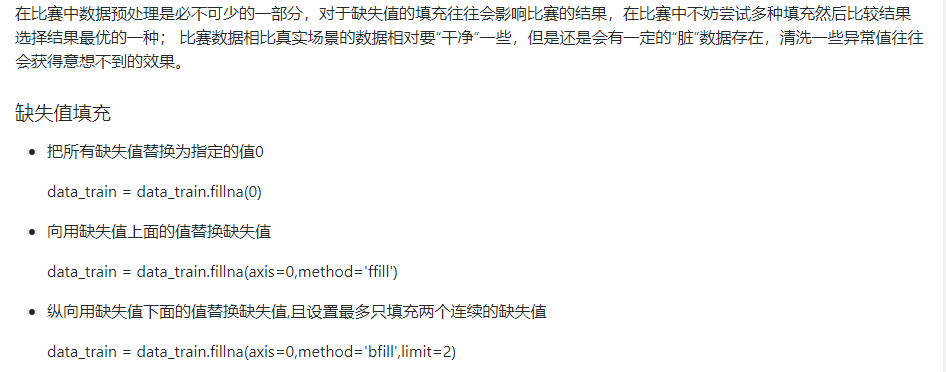

In [6]:
data_train.isnull().sum()

loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n2.1                  40270
n4                  

In [7]:
#  按照平均数填充数值型特征
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
data_test[numerical_fea] = data_test[numerical_fea].fillna(data_test[numerical_fea].median())

#  按照众数填充类别型特征
data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
data_test[category_fea] = data_test[category_fea].fillna(data_test[category_fea].mode())

In [8]:
data_train.isnull().sum()

loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n2.1                      0
n4                  

In [9]:
#查看类别特征
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

#####  时间格式处理

In [11]:
#转化成时间格式
for data in [data_train, data_test]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [12]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

对象类型特征转换到数值

In [14]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [data_train, data_test]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [15]:
'2 years'.split()[0]

'2'

对earliesCreditLine进行预处理

In [16]:
data_train['earliesCreditLine'].sample(5)

id
188387    Aug-1997
685826    Oct-1996
362659    Aug-1988
639985    Jul-1999
134993    Jan-2006
Name: earliesCreditLine, dtype: object

In [17]:
for data in [data_train, data_test]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

类别特征处理

In [18]:
# 部分类别特征
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']
for f in cate_features:
    print(f, '类型数：', data[f].nunique())

grade 类型数： 7
subGrade 类型数： 35
employmentTitle 类型数： 79282
homeOwnership 类型数： 6
verificationStatus 类型数： 3
purpose 类型数： 14
postCode 类型数： 889
regionCode 类型数： 51
applicationType 类型数： 2
initialListStatus 类型数： 2
title 类型数： 12058
policyCode 类型数： 1


像等级这种类别特征，是有优先级的可以labelencode或者自映射

In [20]:
for data in [data_train, data_test]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [21]:
# 类型数在2之上，又不是高维稀疏的,且纯分类特征
for data in [data_train, data_test]:
    data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

###  异常值处理

当你发现异常值后，一定要先分清是什么原因导致的异常值，然后再考虑如何处理。首先，如果这一异常值并不代表一种规律性的，而是极其偶然的现象，或者说你并不想研究这种偶然的现象，这时可以将其删除。其次，如果异常值存在且代表了一种真实存在的现象，那就不能随便删除。在现有的欺诈场景中很多时候欺诈数据本身相对于正常数据勒说就是异常的，我们要把这些异常点纳入，重新拟合模型，研究其规律。能用监督的用监督模型，不能用的还可以考虑用异常检测的算法来做。

注意test的数据不能删。

####  检测异常的方法一：均方差
在统计学中，如果一个数据分布近似正态，那么大约 68% 的数据值会在均值的一个标准差范围内，大约 95% 会在两个标准差范围内，大约 99.7% 会在三个标准差范围内。

In [26]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [29]:
data_train = data_train.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)

正常值    800000
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: term_outliers, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    794259
异常值      5741
Name: interestRate_outliers, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
正常值    792046
异常值      7954
Name: installment_outliers, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
正常值    800000
Name: employmentTitle_outliers, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    799701
异常值       299
Name: homeOwnership_outliers, dtype: int64
homeOwnership_outliers
异常值        62
正常值    159548
Name: isDefault, dtype: int64
**********
正常值    793973
异常值      6027
Name: annualIncome_outliers, dtype: int64
annualIncome_outliers
异常值       756
正常值    158854
Name: isDefault,

例如可以看到异常值在两个变量上的分布几乎复合整体的分布，如果异常值都属于为1的用户数据里面代表什么呢？

In [30]:
#删除异常值
for fea in numerical_fea:
    data_train = data_train[data_train[fea+'_outliers']=='正常值']
    data_train = data_train.reset_index(drop=True) 

###  检测异常的方法二：箱型图

总结一句话：四分位数会将数据分为三个点和四个区间，IQR = Q3 -Q1，下触须=Q1 − 1.5x IQR，上触须=Q3 + 1.5x IQR；

###  数据分桶

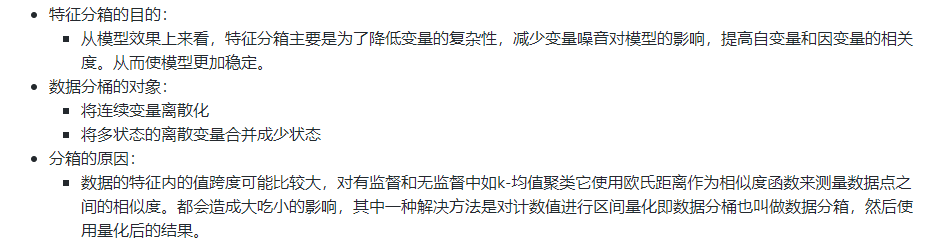

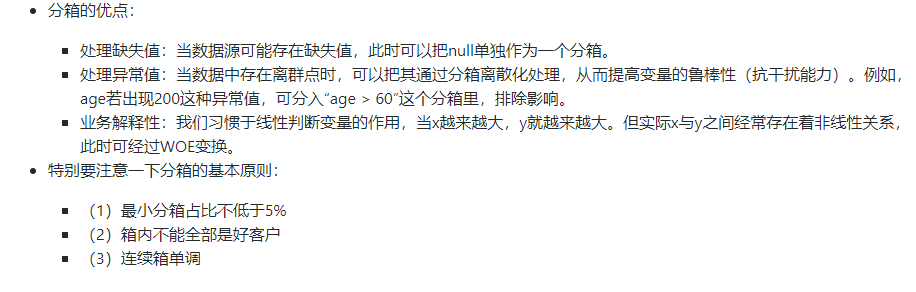

#### 1;固定宽度分箱
当数值横跨多个数量级时，最好按照 10 的幂（或任何常数的幂）来进行分组：0-9、10-99、100-999、1000-9999，等等。固定宽度分箱非常容易计算，但如果计数值中有比较大的缺口，就会产生很多没有任何数据的空箱子。

In [31]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000
data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)

In [32]:
## 通过对数函数映射到指数宽度分箱
data['loanAmnt_bin2'] = np.floor(np.log10(data['loanAmnt']))

####  分位数分箱

####  卡方分箱及其他分箱方法的尝试(待尝试）

###  特征交互

In [38]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test[col + '_target_mean'] = data_test[col].map(temp_dict)

In [39]:
"""
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n2.1','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')
"""

"\n# 其他衍生变量 mean 和 std\nfor df in [data_train, data_test_a]:\n    for item in ['n0','n1','n2','n2.1','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:\n        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')\n        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')\n"

#####  特征交互，这里没有深入去做，值得加强，可以好好做一下。

In [40]:
data_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n7_outliers,n8_outliers,n9_outliers,n10_outliers,n11_outliers,n12_outliers,n13_outliers,n14_outliers,grade_target_mean,subGrade_target_mean
0,35000.0,5,19.52,917.97,5,E2,320.0,2.0,2,110000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.386234,0.380444
1,18000.0,5,18.49,461.90,4,D2,219843.0,5.0,0,46000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.304227,0.298190
2,12000.0,5,16.99,298.17,4,D3,31698.0,8.0,0,74000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.304227,0.302541
3,2050.0,3,7.69,63.95,1,A4,180083.0,9.0,0,35000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.059838,0.065532
4,11500.0,3,14.98,398.54,3,C3,214017.0,1.0,1,30000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.224522,0.224686


In [41]:
data_test.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n8,n9,n10,n11,n12,n13,n14,issueDateDT,grade_target_mean,subGrade_target_mean
id,,,,,,,,,,,,,,,,,,,,,
800000,14000.0,3,10.99,458.28,2,B3,7027.0,10.0,0,80000.0,...,19.0,6.0,17.0,0.0,0.0,1.0,3.0,2587,0.131210,0.128111
800001,20000.0,5,14.65,472.14,3,C5,60426.0,10.0,0,50000.0,...,9.0,3.0,5.0,0.0,0.0,2.0,2.0,2952,0.224522,0.262219
800002,12000.0,3,19.99,445.91,4,D4,23547.0,2.0,1,60000.0,...,6.0,4.0,12.0,0.0,0.0,0.0,7.0,3410,0.304227,0.325175
800003,17500.0,5,14.31,410.02,3,C4,636.0,4.0,0,37000.0,...,14.0,2.0,10.0,0.0,0.0,0.0,3.0,2710,0.224522,0.251584
800004,35000.0,3,17.09,1249.42,4,D1,368446.0,0.0,1,80000.0,...,18.0,11.0,19.0,0.0,0.0,0.0,1.0,3775,0.304227,0.279444


###  特征编码

labelEncode 直接放入树模型中

In [43]:
#label-encode:subGrade,postCode,title
# 高维类别特征需要进行转换
for col in tqdm(['employmentTitle', 'postCode', 'title','subGrade']):
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test[col] = le.transform(list(data_test[col].astype(str).values))
print('Label Encoding 完成')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.04s/it]

Label Encoding 完成


### "逻辑回归"  等模型要单独增加的特征工程

对特征做归一化，去除相关性高的特征

归一化目的是让训练过程更好更快的收敛，避免特征大吃小的问题

去除相关性是增加模型的可解释性，加快预测过程。

###  特征选择
特征选择技术可以精简掉无用的特征，以降低最终模型的复杂性，它的最终目的是得到一个简约模型，在不降低预测准确率或对预测准确率影响不大的情况下提高计算速度。

特征选择的方法：

####  1 Filter
    方差选择法
    相关系数法（pearson 相关系数）
    卡方检验
    互信息法
#### 2 Wrapper （RFE）
    递归特征消除法
#### 3 Embedded
    基于惩罚项的特征选择法
    基于树模型的特征选择

####  Filter
基于特征间的关系进行筛选

#### 方差选择法
方差选择法中，先要计算各个特征的方差，然后根据设定的阈值，选择方差大于阈值的特征

In [ ]:
from sklearn.feature_selection import VarianceThreshold
#其中参数threshold为方差的阈值
VarianceThreshold(threshold=3).fit_transform(train,target_train)

#### 相关系数法
Pearson 相关系数 皮尔森相关系数是一种最简单的，可以帮助理解特征和响应变量之间关系的方法，该方法衡量的是变量之间的线性相关性。 结果的取值区间为 [-1，1] ， -1 表示完全的负相关， +1表示完全的正相关，0 表示没有线性相关。

In [ ]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数

SelectKBest(k=5).fit_transform(train,target_train)

#### 卡方检验

经典的卡方检验是用于检验自变量对因变量的相关性。 假设自变量有N种取值，因变量有M种取值，考虑自变量等于i且因变量等于j的样本频数的观察值与期望的差距。 其统计量如下： χ2=∑(A−T)2T，其中A为实际值，T为理论值
(注：卡方只能运用在正定矩阵上，否则会报错Input X must be non-negative)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#参数k为选择的特征个数

SelectKBest(chi2, k=5).fit_transform(train,target_train)

#### 互信息法

经典的互信息也是评价自变量对因变量的相关性的。 在feature_selection库的SelectKBest类结合最大信息系数法可以用于选择特征，相关代码如下：

In [ ]:
from sklearn.feature_selection import SelectKBest
from minepy import MINE
#由于MINE的设计不是函数式的，定义mic方法将其为函数式的，
#返回一个二元组，二元组的第2项设置成固定的P值0.5
def mic(x, y):
    m = MINE()
    m.compute_score(x, y)
    return (m.mic(), 0.5)
#参数k为选择的特征个数
SelectKBest(lambda X, Y: array(map(lambda x:mic(x, Y), X.T)).T, k=2).fit_transform(train,target_train)

#### Wrapper （Recursive feature elimination，RFE）
递归特征消除法 递归消除特征法使用一个基模型来进行多轮训练，每轮训练后，消除若干权值系数的特征，再基于新的特征集进行下一轮训练。 在feature_selection库的RFE类可以用于选择特征，相关代码如下（以逻辑回归为例）：

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#递归特征消除法，返回特征选择后的数据
#参数estimator为基模型
#参数n_features_to_select为选择的特征个数

RFE(estimator=LogisticRegression(), n_features_to_select=2).fit_transform(train,target_train)

####  Embedded
基于惩罚项的特征选择法 使用带惩罚项的基模型，除了筛选出特征外，同时也进行了降维。 在feature_selection库的SelectFromModel类结合逻辑回归模型可以用于选择特征，相关代码如下：

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
#带L1惩罚项的逻辑回归作为基模型的特征选择

SelectFromModel(LogisticRegression(penalty="l1", C=0.1)).fit_transform(train,target_train)

#### 基于树模型的特征选择 
树模型中GBDT也可用来作为基模型进行特征选择。 在feature_selection库的SelectFromModel类结合GBDT模型可以用于选择特征，相关代码如下：

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
#GBDT作为基模型的特征选择
SelectFromModel(GradientBoostingClassifier()).fit_transform(train,target_train)

In [47]:
data_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n7_outliers,n8_outliers,n9_outliers,n10_outliers,n11_outliers,n12_outliers,n13_outliers,n14_outliers,grade_target_mean,subGrade_target_mean
0,35000.0,5,19.52,917.97,5,21,67756,2.0,2,110000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.386234,0.380444
1,18000.0,5,18.49,461.90,4,16,264887,5.0,0,46000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.304227,0.298190
2,12000.0,5,16.99,298.17,4,17,65713,8.0,0,74000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.304227,0.302541
3,2050.0,3,7.69,63.95,1,3,230319,9.0,0,35000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.059838,0.065532
4,11500.0,3,14.98,398.54,3,12,260012,1.0,1,30000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.224522,0.224686


In [50]:
data_train.index.name = 'id'
data_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n7_outliers,n8_outliers,n9_outliers,n10_outliers,n11_outliers,n12_outliers,n13_outliers,n14_outliers,grade_target_mean,subGrade_target_mean
id,,,,,,,,,,,,,,,,,,,,,
0,35000.0,5,19.52,917.97,5,21,67756,2.0,2,110000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.386234,0.380444
1,18000.0,5,18.49,461.90,4,16,264887,5.0,0,46000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.304227,0.298190
2,12000.0,5,16.99,298.17,4,17,65713,8.0,0,74000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.304227,0.302541
3,2050.0,3,7.69,63.95,1,3,230319,9.0,0,35000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.059838,0.065532
4,11500.0,3,14.98,398.54,3,12,260012,1.0,1,30000.0,...,正常值,正常值,正常值,正常值,正常值,正常值,正常值,正常值,0.224522,0.224686


In [45]:
data_train['issueDate']

0        2014-07-01
1        2012-08-01
2        2015-10-01
3        2014-10-01
4        2014-01-01
            ...    
612737   2014-10-01
612738   2016-07-01
612739   2015-10-01
612740   2015-02-01
612741   2018-08-01
Name: issueDate, Length: 612742, dtype: datetime64[ns]

In [52]:
x_train = data_train.drop(['isDefault'], axis=1)
#计算协方差
data_corr = x_train.corrwith(data_train.isDefault) #计算相关性
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values

In [53]:
result

,features,corr
0,loanAmnt,0.061056
1,term,0.174659
2,interestRate,0.254421
3,installment,0.043117
4,grade,0.256237
5,subGrade,0.262355
6,employmentTitle,0.003157
7,employmentLength,-0.014058
8,homeOwnership,0.053502
9,annualIncome,-0.065541


<AxesSubplot:title={'center':'Correlation of Numeric Features with Price'}>

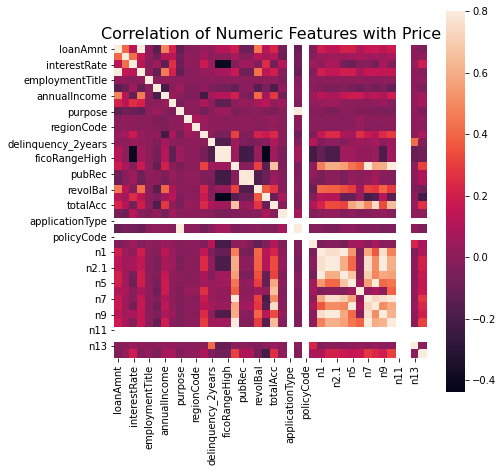

In [54]:
# 当然也可以直接看图
data_numeric = data_train[numerical_fea]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

In [55]:
features = [f for f in data_train.columns if f not in ['id','issueDate','isDefault'] and '_outliers' not in f]
x_train = data_train[features]
x_test = data_test[features]
y_train = data_train['isDefault']

In [56]:
x_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n8,n9,n10,n11,n12,n13,n14,issueDateDT,grade_target_mean,subGrade_target_mean
id,,,,,,,,,,,,,,,,,,,,,
0,35000.0,5,19.52,917.97,5,21,67756,2.0,2,110000.0,...,12.0,2.0,7.0,0.0,0.0,0.0,2.0,2587,0.386234,0.380444
1,18000.0,5,18.49,461.90,4,16,264887,5.0,0,46000.0,...,13.0,5.0,13.0,0.0,0.0,0.0,2.0,1888,0.304227,0.298190
2,12000.0,5,16.99,298.17,4,17,65713,8.0,0,74000.0,...,5.0,3.0,11.0,0.0,0.0,0.0,4.0,3044,0.304227,0.302541
3,2050.0,3,7.69,63.95,1,3,230319,9.0,0,35000.0,...,18.0,3.0,12.0,0.0,0.0,0.0,3.0,2679,0.059838,0.065532
4,11500.0,3,14.98,398.54,3,12,260012,1.0,1,30000.0,...,21.0,4.0,8.0,0.0,0.0,0.0,2.0,2406,0.224522,0.224686


In [57]:
x_test.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n8,n9,n10,n11,n12,n13,n14,issueDateDT,grade_target_mean,subGrade_target_mean
id,,,,,,,,,,,,,,,,,,,,,
800000,14000.0,3,10.99,458.28,2,7,242628,10.0,0,80000.0,...,19.0,6.0,17.0,0.0,0.0,1.0,3.0,2587,0.131210,0.128111
800001,20000.0,5,14.65,472.14,3,14,231013,10.0,0,50000.0,...,9.0,3.0,5.0,0.0,0.0,2.0,2.0,2952,0.224522,0.262219
800002,12000.0,3,19.99,445.91,4,18,150296,2.0,1,60000.0,...,6.0,4.0,12.0,0.0,0.0,0.0,7.0,3410,0.304227,0.325175
800003,17500.0,5,14.31,410.02,3,13,234706,4.0,0,37000.0,...,14.0,2.0,10.0,0.0,0.0,0.0,3.0,2710,0.224522,0.251584
800004,35000.0,3,17.09,1249.42,4,15,201079,0.0,1,80000.0,...,18.0,11.0,19.0,0.0,0.0,0.0,1.0,3775,0.304227,0.279444


In [58]:
y_train

id
0         1
1         0
2         0
3         0
4         0
         ..
612737    1
612738    0
612739    1
612740    0
612741    0
Name: isDefault, Length: 612742, dtype: int64

In [59]:
x_train.shape

(612742, 47)

In [61]:
x_test.shape

(200000, 47)

In [92]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [93]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")
    return cat_train, cat_test

In [64]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.748548	valid_1's auc: 0.729674
[400]	training's auc: 0.764273	valid_1's auc: 0.730545
Early stopping, best iteration is:
[378]	training's auc: 0.762647	valid_1's auc: 0.730588
[0.7305878656806359]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.748923	valid_1's auc: 0.732086
[400]	training's auc: 0.76451	valid_1's auc: 0.732581
[600]	training's auc: 0.777716	valid_1's auc: 0.732534
Early stopping, best iteration is:
[512]	training's auc: 0.771893	valid_1's auc: 0.732881
[0.7305878656806359, 0.7328807657858611]
************************************ 3 ************************************
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.74832	valid_1's auc: 0.732745
[400]	training's

In [68]:
x_train.shape[0]

612742

In [71]:
lgb_test

array([0.01596276, 0.07664022, 0.12738228, ..., 0.03609429, 0.03176708,
       0.00461699])

In [72]:
sub = pd.DataFrame()
sub['id'] = x_test.index
sub['isDefault'] = lgb_test
sub.to_csv('submission_lgbr_0925.csv',index=False)

In [73]:
xgb_train, xgb_test = xgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[15:15:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.69651	eval-auc:0.69442
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.73118	eval-auc:0.72425
[400]	train-auc:0.74009	eval-auc:0.72848
[600]	train-auc:0.74601	eval-auc:0.73008
[800]	train-auc:0.75103	eval-auc:0.73089
[1000]	train-auc:0.75567	eval-auc:0.73164
[1200]	train-auc:0.75980	eval-auc:0.73196
[1400]	train-auc:0.76373	eval-auc:0.73225
[1600]	train-auc:0.76748	eval-auc:0.73241
[1800]	train-auc:0.77104	ev

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

###  看趋势   XGB 效果 和 LGB  差不多 应该是

In [78]:
cat_train, cat_test = cat_model(x_train, y_train, x_test)

************************************ 1 ************************************
0:	learn: 0.3944373	test: 0.3964812	best: 0.3964812 (0)	total: 44.7ms	remaining: 14m 54s
500:	learn: 0.3726995	test: 0.3755297	best: 0.3755297 (500)	total: 22.6s	remaining: 14m 37s
1000:	learn: 0.3711169	test: 0.3749412	best: 0.3749412 (1000)	total: 48.7s	remaining: 15m 23s
1500:	learn: 0.3699070	test: 0.3746566	best: 0.3746566 (1500)	total: 1m 14s	remaining: 15m 23s
2000:	learn: 0.3688553	test: 0.3745035	best: 0.3745022 (1996)	total: 1m 42s	remaining: 15m 19s
2500:	learn: 0.3678881	test: 0.3744102	best: 0.3744055 (2486)	total: 2m 10s	remaining: 15m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3743910584
bestIteration = 2651

Shrink model to first 2652 iterations.
[0.7315779839616356]
************************************ 2 ************************************
0:	learn: 0.3947582	test: 0.3951348	best: 0.3951348 (0)	total: 57.6ms	remaining: 19m 12s
500:	learn: 0.3729988	test: 0.3742207	

TypeError: cannot unpack non-iterable NoneType object

In [94]:
cat_train, cat_test = cat_model(x_train, y_train, x_test)

************************************ 1 ************************************
0:	learn: 0.3944373	test: 0.3964812	best: 0.3964812 (0)	total: 45.1ms	remaining: 15m 2s
500:	learn: 0.3726995	test: 0.3755297	best: 0.3755297 (500)	total: 25.5s	remaining: 16m 30s
1000:	learn: 0.3711169	test: 0.3749412	best: 0.3749412 (1000)	total: 52.1s	remaining: 16m 28s
1500:	learn: 0.3699070	test: 0.3746566	best: 0.3746566 (1500)	total: 1m 18s	remaining: 16m 9s
2000:	learn: 0.3688553	test: 0.3745035	best: 0.3745022 (1996)	total: 1m 45s	remaining: 15m 46s
2500:	learn: 0.3678881	test: 0.3744102	best: 0.3744055 (2486)	total: 2m 11s	remaining: 15m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3743910584
bestIteration = 2651

Shrink model to first 2652 iterations.
[0.7315779839616356]
************************************ 2 ************************************
0:	learn: 0.3947582	test: 0.3951348	best: 0.3951348 (0)	total: 60.6ms	remaining: 20m 12s
500:	learn: 0.3729988	test: 0.3742207	be

In [95]:
sub = pd.DataFrame()
sub['id'] = x_test.index
sub['isDefault'] = cat_test
sub.to_csv('submission_catr_0925.csv',index=False)